#### CSC 215 Artificial Intelligence (Spring 2023)

#### Dr. Haiquan Chen, Dept of Computer Scicence

#### California State University, Sacramento



# CSC 215  Lab 15:  GPU and Transfer Learning


### Please run this lab in Google Colab.  

**You may want to (1) mount your google drive so colab can access your files on google drive and (2) use Google GPU  for model training.** 


## 1. Mount Google drive to colab

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

## Helpful Functions for Tensorflow (Little Gems)

The following functions will be used with TensorFlow to help preprocess the data.  They allow you to build the feature vector for a neural network. 

* Predictors/Inputs 
    * Fill any missing inputs with the median for that column.  Use **missing_median**.
    * Encode textual/categorical values with **encode_text_dummy**.
    * Encode numeric values with **encode_numeric_zscore**.
* Output
    * Discard rows with missing outputs.
    * Encode textual/categorical values with **encode_text_index**.
    * Do not encode output numeric values.
* Produce final feature vectors (x) and expected output (y) with **to_xy**.

In [4]:
from collections.abc import Sequence
from sklearn import preprocessing
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import shutil
import os


# Encode text values to dummy variables(i.e. [1,0,0],[0,1,0],[0,0,1] for red,green,blue)
def encode_text_dummy(df, name):
    dummies = pd.get_dummies(df[name])
    for x in dummies.columns:
        dummy_name = "{}-{}".format(name, x)
        df[dummy_name] = dummies[x]
    df.drop(name, axis=1, inplace=True)


# Encode text values to indexes(i.e. [1],[2],[3] for red,green,blue).
def encode_text_index(df, name):
    le = preprocessing.LabelEncoder()
    df[name] = le.fit_transform(df[name])
    return le.classes_


# Encode a numeric column as zscores
def encode_numeric_zscore(df, name, mean=None, sd=None):
    if mean is None:
        mean = df[name].mean()

    if sd is None:
        sd = df[name].std()

    df[name] = (df[name] - mean) / sd


# Convert all missing values in the specified column to the median
def missing_median(df, name):
    med = df[name].median()
    df[name] = df[name].fillna(med)


# Convert all missing values in the specified column to the default
def missing_default(df, name, default_value):
    df[name] = df[name].fillna(default_value)


# Convert a Pandas dataframe to the x,y inputs that TensorFlow needs
def to_xy(df, target):
    result = []
    for x in df.columns:
        if x != target:
            result.append(x)
    # find out the type of the target column. 
    target_type = df[target].dtypes
    target_type = target_type[0] if isinstance(target_type, Sequence) else target_type
    # Encode to int for classification, float otherwise. TensorFlow likes 32 bits.
    if target_type in (np.int64, np.int32):
        # Classification
        dummies = pd.get_dummies(df[target])
        return df[result].values.astype(np.float32), dummies.values.astype(np.float32)
    else:
        # Regression
        return df[result].values.astype(np.float32), df[target].values.astype(np.float32)

# Nicely formatted time string
def hms_string(sec_elapsed):
    h = int(sec_elapsed / (60 * 60))
    m = int((sec_elapsed % (60 * 60)) / 60)
    s = sec_elapsed % 60
    return "{}:{:>02}:{:>05.2f}".format(h, m, s)


# Regression chart.
def chart_regression(pred,y,sort=True):
    t = pd.DataFrame({'pred' : pred, 'y' : y.flatten()})
    if sort:
        t.sort_values(by=['y'],inplace=True)
    a = plt.plot(t['y'].tolist(),label='expected')
    b = plt.plot(t['pred'].tolist(),label='prediction')
    plt.ylabel('output')
    plt.legend()
    plt.show()

# Remove all rows where the specified column is +/- sd standard deviations
def remove_outliers(df, name, sd):
    drop_rows = df.index[(np.abs(df[name] - df[name].mean()) >= (sd * df[name].std()))]
    df.drop(drop_rows, axis=0, inplace=True)


# Encode a column to a range between normalized_low and normalized_high.
def encode_numeric_range(df, name, normalized_low=-1, normalized_high=1,
                         data_low=None, data_high=None):
    if data_low is None:
        data_low = min(df[name])
        data_high = max(df[name])

    df[name] = ((df[name] - data_low) / (data_high - data_low)) \
               * (normalized_high - normalized_low) + normalized_low


## 2. Switch and Verify GPU

### To enable GPU backend for your notebook. Runtime->Change runtime type->Hardware Accelerator->GPU.

In [ ]:
import tensorflow as tf

tf.test.gpu_device_name()

'/device:GPU:0'

## 3. Example:  Using GPU for classification on the fashion_mnist dataset 

https://github.com/zalandoresearch/fashion-mnist

### 3.1 Load datasets


Dataset of 60,000 28x28 grayscale images of 10 fashion categories, along with a test set of 10,000 images. This dataset can be used as a drop-in replacement for MNIST. The class labels are:


Label	Description
0	T-shirt/top
1	Trouser
2	Pullover
3	Dress
4	Coat
5	Sandal
6	Shirt
7	Sneaker
8	Bag
9	Ankle boot





https://keras.io/datasets/

In [1]:
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.datasets import fashion_mnist

(x_train, y_train), (x_test, y_test) = fashion_mnist.load_data()

print("Shape of x_train: {}".format(x_train.shape))
print("Shape of y_train: {}".format(y_train.shape))
print()
print("Shape of x_test: {}".format(x_test.shape))
print("Shape of y_test: {}".format(y_test.shape))

4423680/4422102 [==============================] - 0s 0us/step
Shape of x_train: (60000, 28, 28)
Shape of y_train: (60000,)

Shape of x_test: (10000, 28, 28)
Shape of y_test: (10000,)


In [2]:
y_train

array([9, 0, 0, ..., 3, 0, 5], dtype=uint8)

### 3.2 Display the Images 

The following code shows what the MNIST files contain.

In [5]:
# Single MNIST digit
first = x_train[0]

pd.DataFrame(first)

,0,1,2,3,4,5,6,7,8,9,...,18,19,20,21,22,23,24,25,26,27
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,1,4,0,0,0,0,1,1,0
4,0,0,0,0,0,0,0,0,0,0,...,54,0,0,0,1,3,4,0,0,3
5,0,0,0,0,0,0,0,0,0,0,...,144,123,23,0,0,0,0,12,10,0
6,0,0,0,0,0,0,0,0,0,0,...,107,156,161,109,64,23,77,130,72,15
7,0,0,0,0,0,0,0,0,0,0,...,216,163,127,121,122,146,141,88,172,66
8,0,0,0,0,0,0,0,0,0,1,...,223,223,215,213,164,127,123,196,229,0
9,0,0,0,0,0,0,0,0,0,0,...,235,227,224,222,224,221,223,245,173,0


Image (#0): Which is for label '9'


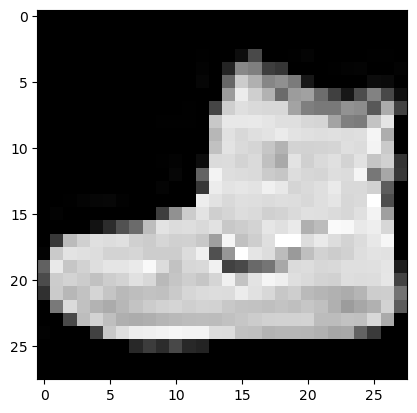

In [6]:
# let's show it as image


%matplotlib inline
import matplotlib.pyplot as plt

sample = 0    #  change this number to select another sample


plt.imshow(x_train[sample], cmap='gray')

print("Image (#{}): Which is for label '{}'".format(sample,y_train[sample]))

### 3.3 Define CNN

In [7]:
batch_size = 128

#### Let's create x (images) first.        

####  x must be 4D array

#### You must explicitly declare the depth of the input image. For example, a full-color image with all 3 RGB channels will have a depth of 3. 

In other words, we need to transform our dataset from the shape (n, rows, cols) to (n, rows, cols, depth).

#### Our MNIST images only have a depth of 1, but we must explicitly declare that.

In [8]:
x_train = x_train.reshape(x_train.shape[0], 28, 28, 1)
x_test = x_test.reshape(x_test.shape[0], 28, 28, 1)

In [9]:
print(x_train.shape)
print(x_test.shape)

(60000, 28, 28, 1)
(10000, 28, 28, 1)


In [10]:
x_train.dtype

dtype('uint8')

In [11]:
# convert to float32 for normalization
x_train = x_train.astype('float32')
x_test = x_test.astype('float32')

In [12]:
# normalize the data values to the range [0, 1]
x_train /= 255
x_test /= 255

In [13]:
print('x_train shape:', x_train.shape)
print('x_test shape:', x_test.shape)
print("Training samples: {}".format(x_train.shape[0]))
print("Test samples: {}".format(x_test.shape[0]))

x_train shape: (60000, 28, 28, 1)
x_test shape: (10000, 28, 28, 1)
Training samples: 60000
Test samples: 10000


####  Now we have x ready. Let's create y (class labels)

In [14]:
print(y_train.shape)
print(y_train[:10])

(60000,)
[9 0 0 3 0 2 7 2 5 5]


#### For classification, TensorFlow requires y in one hot-encoded format. 

In [16]:
import tensorflow as tf

num_classes = 10

# Converts a class vector (integers) to binary class matrix.   One-hot encoding!  Use with categorical_crossentropy.
y_train = tf.keras.utils.to_categorical(y_train, num_classes)
y_test = tf.keras.utils.to_categorical(y_test, num_classes)

In [17]:
pd.DataFrame(y_train)

,0,1,2,3,4,5,6,7,8,9
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
1,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
4,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...
59995,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
59996,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
59997,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
59998,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [18]:
pd.DataFrame(y_test)

,0,1,2,3,4,5,6,7,8,9
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
1,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...
9995,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
9996,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
9997,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
9998,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [19]:
y_train.shape, y_test.shape

((60000, 10), (10000, 10))

#### Build the model

In [20]:
# Load modules
from tensorflow.keras.datasets import mnist
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Flatten
from tensorflow.keras.layers import Conv2D, MaxPooling2D


model = Sequential()

In [21]:
img_rows = 28

img_cols = 28

input_shape = (img_rows, img_cols, 1)        # this is the shape of each sample

model.add(Conv2D(32, kernel_size=(3, 3), strides=(1, 1), padding='valid',
                 activation='relu',
                 input_shape=input_shape))    #  in this case, input_shape = (img_rows, img_cols, 1)

Next, we can simply add more layers to our model

In [22]:
# Note that number of filters from previous layer become the number of channels for current layer's input image.

model.add(MaxPooling2D(pool_size=(2, 2), strides=None))

model.add(Conv2D(16, kernel_size=(3, 3), strides=(1, 1), padding='valid', activation='relu'))

model.add(MaxPooling2D(pool_size=(2, 2), strides=None))

model.add(Dropout(0.25)) 

So far, for model parameters, we've added two Convolution layers. To complete our model architecture, let's add a fully connected layer and then the output layer:

In [23]:
model.add(Flatten())

model.add(Dense(128, activation='relu'))

model.add(Dropout(0.5))

model.add(Dense(num_classes, activation='softmax'))

In [25]:
from tensorflow.keras.optimizers import Adam

# show not only log loss but also accuracy for each epoch using metrics=['accuracy']

model.compile(loss=tf.keras.losses.categorical_crossentropy, optimizer=Adam(lr=0.001, decay=1e-6), metrics=['accuracy'])


In [63]:
import time

start_time = time.time()

# 100% of dataset


es = EarlyStopping(monitor='val_loss', mode='auto', min_delta=0.001, verbose=1, patience=3)   
# auto : minimize loss or maximize accuracy.


model.fit(x_train, y_train,     
          batch_size=batch_size,
          epochs=100,
          verbose=2,
          validation_data=(x_test, y_test), callbacks=[es])

elapsed_time = time.time() - start_time

print("Elapsed time: {}".format(hms_string(elapsed_time)))

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
Train on 60000 samples, validate on 10000 samples
Epoch 1/100
60000/60000 - 9s - loss: 0.7899 - acc: 0.7123 - val_loss: 0.4937 - val_acc: 0.8158
Epoch 2/100
60000/60000 - 2s - loss: 0.5230 - acc: 0.8081 - val_loss: 0.4249 - val_acc: 0.8433
Epoch 3/100
60000/60000 - 2s - loss: 0.4655 - acc: 0.8298 - val_loss: 0.3983 - val_acc: 0.8540
Epoch 4/100
60000/60000 - 2s - loss: 0.4266 - acc: 0.8431 - val_loss: 0.3630 - val_acc: 0.8677
Epoch 5/100
60000/60000 - 2s - loss: 0.4002 - acc: 0.8541 - val_loss: 0.3468 - val_acc: 0.8731
Epoch 6/100
60000/60000 - 2s - loss: 0.3843 - acc: 0.8607 - val_loss: 0.3291 - val_acc: 0.8785
Epoch 7/100
60000/60000 - 2s - loss: 0.3664 - acc: 0.8648 - val_loss: 0.3166 - val_acc: 0.8851
Epoch 8/100
60000/60000 - 2s - loss: 0.3544 - acc: 0.8703 - val_loss: 0.3163 - val_acc: 0.8837
Epoch 9/100
60000/60000 - 2s - loss: 0.3428 - acc: 0.8753 - val_loss: 0.3083 - val_acc: 0.8873
E

#### Evaluate Metrics using Sklearn

In [64]:
from sklearn import metrics

y_true = np.argmax(y_test,axis=1)

pred = model.predict(x_test)
pred = np.argmax(pred,axis=1)

score = metrics.accuracy_score(y_true, pred)
print('Accuracy: {}'.format(score))


f1 = metrics.f1_score(y_true, pred, average='weighted')
print('Averaged F1: {}'.format(f1))

           
print(metrics.classification_report(y_true, pred))

Accuracy: 0.9005
Averaged F1: 0.9010124240523064
              precision    recall  f1-score   support

           0       0.89      0.81      0.85      1000
           1       0.99      0.97      0.98      1000
           2       0.86      0.85      0.86      1000
           3       0.88      0.92      0.90      1000
           4       0.84      0.87      0.85      1000
           5       0.98      0.98      0.98      1000
           6       0.68      0.72      0.70      1000
           7       0.95      0.96      0.96      1000
           8       0.98      0.97      0.97      1000
           9       0.97      0.97      0.97      1000

    accuracy                           0.90     10000
   macro avg       0.90      0.90      0.90     10000
weighted avg       0.90      0.90      0.90     10000



## 4. Let's do transfer learning!

In [28]:
from tensorflow.keras.datasets import fashion_mnist

(x_train, y_train), (x_test, y_test) = fashion_mnist.load_data()

print("Shape of x_train: {}".format(x_train.shape))
print("Shape of y_train: {}".format(y_train.shape))
print()
print("Shape of x_test: {}".format(x_test.shape))
print("Shape of y_test: {}".format(y_test.shape))

Shape of x_train: (60000, 28, 28)
Shape of y_train: (60000,)

Shape of x_test: (10000, 28, 28)
Shape of y_test: (10000,)


### We are going to use VGG16

https://neurohive.io/en/popular-networks/vgg16/

https://keras.io/applications/


VGG16 works on color images so we need to convert grey to RGB.

Examine to understand the  code in the following cell:

In [29]:
new_x_train = []

for image in x_train:
  newImage = np.stack((image, image, image), axis=-1)
  new_x_train.append(newImage)
  
 

new_x_train= np.asarray(new_x_train)
  

In [30]:
new_x_train.shape

(60000, 28, 28, 3)

Now we get images with 3 channels!

In [31]:
new_x_test = []

for image in x_test:
  newImage = np.stack((image, image, image), axis=-1)
  new_x_test.append(newImage)
    
    
new_x_test = np.asarray(new_x_test)    

In [32]:
new_x_test.shape

(10000, 28, 28, 3)

### Upsampling


#### VGG16 supports down to 32x32 images as an input.   However the fashion-mnist images are too low in terms of resolutions (28, 28) so we need to do upsampling


We use resize(), provided by scikit-image
https://scikit-image.org/

Check the RAM bar!  :)    You need at least 12 GB RAM to use the code!

In [35]:
# pip install scikit-image

from skimage.transform import resize



new_x_train_64x64 = np.zeros((60000, 64, 64, 3))

for x in range(len(new_x_train)):
  image = resize(new_x_train[x], (64, 64))       # resize also normalizes your image
  new_x_train_64x64[x] = image

# this process may take about a few minutes ....



new_x_test_64x64 = np.zeros((10000, 64, 64, 3))

for x in range(len(new_x_test)):
  image = resize(new_x_test[x], (64, 64))
  new_x_test_64x64[x] = image
    
# this process may take about a few minutes ....




In [36]:
new_x_train_64x64.shape

(60000, 64, 64, 3)

In [37]:
new_x_test_64x64.shape

(10000, 64, 64, 3)

In [38]:
y_train.shape

(60000,)

In [39]:
y_test.shape

(10000,)

In [40]:

# Convert class vectors to one hot format
y_train = tf.keras.utils.to_categorical(y_train, 10)
y_test = tf.keras.utils.to_categorical(y_test, 10)

#### Build model

In [41]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Flatten
from tensorflow.keras.layers import Conv2D, MaxPooling2D

from tensorflow.keras.applications.vgg16 import VGG16


vgg_model = VGG16(weights='imagenet', include_top=False, input_shape=(64, 64, 3))   #  first hidden layer


model = Sequential()


for layer in vgg_model.layers:
    model.add(layer)


model.summary()

58892288/58889256 [==============================] - 3s 0us/step
Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
block1_conv1 (Conv2D)        (None, 64, 64, 64)        1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 64, 64, 64)        36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 32, 32, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 32, 32, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 32, 32, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 16, 16, 128)       0         
_______________________________________________________

In [42]:
for layer in model.layers:
    layer.trainable = False



In [43]:
model.add(Flatten())

model.add(Dense(10, activation='softmax'))



In [ ]:
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint


model.compile(loss=keras.losses.categorical_crossentropy, optimizer=Adam(lr=0.001, decay=1e-6), metrics=['accuracy'])

monitor = EarlyStopping(monitor='val_loss', min_delta=1e-3, patience=5, verbose=1, mode='auto')


model.fit(new_x_train_64x64, y_train, 
          batch_size=128,
          epochs=10,    # change this to 100
          verbose=2,
          callbacks=[monitor],
          validation_data=(new_x_test_64x64, y_test))

W0812 20:04:28.709821 140673025324928 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/optimizers.py:790: The name tf.train.Optimizer is deprecated. Please use tf.compat.v1.train.Optimizer instead.

W0812 20:04:28.817705 140673025324928 deprecation.py:323] From /usr/local/lib/python3.6/dist-packages/tensorflow/python/ops/math_grad.py:1250: add_dispatch_support.<locals>.wrapper (from tensorflow.python.ops.array_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


Train on 60000 samples, validate on 10000 samples
Epoch 1/100
 - 35s - loss: 0.5499 - acc: 0.8214 - val_loss: 0.4121 - val_acc: 0.8520
Epoch 2/100
 - 28s - loss: 0.3570 - acc: 0.8755 - val_loss: 0.3570 - val_acc: 0.8762
Epoch 3/100
 - 29s - loss: 0.3210 - acc: 0.8868 - val_loss: 0.3385 - val_acc: 0.8794
Epoch 4/100
 - 29s - loss: 0.3015 - acc: 0.8927 - val_loss: 0.3269 - val_acc: 0.8827
Epoch 5/100
 - 29s - loss: 0.2871 - acc: 0.8974 - val_loss: 0.3199 - val_acc: 0.8854
Epoch 6/100
 - 29s - loss: 0.2773 - acc: 0.9014 - val_loss: 0.3171 - val_acc: 0.8892
Epoch 7/100
 - 29s - loss: 0.2694 - acc: 0.9033 - val_loss: 0.3163 - val_acc: 0.8891
Epoch 8/100
 - 29s - loss: 0.2618 - acc: 0.9063 - val_loss: 0.3063 - val_acc: 0.8912
Epoch 9/100
 - 30s - loss: 0.2564 - acc: 0.9072 - val_loss: 0.3090 - val_acc: 0.8905
Epoch 10/100
 - 30s - loss: 0.2505 - acc: 0.9097 - val_loss: 0.3021 - val_acc: 0.8924
Epoch 11/100
 - 30s - loss: 0.2468 - acc: 0.9109 - val_loss: 0.2970 - val_acc: 0.8935
Epoch 12/100


In [ ]:
from sklearn import metrics


y_true = np.argmax(y_test,axis=1)

pred = model.predict(new_x_test_64x64)
pred = np.argmax(pred,axis=1)

f1 = metrics.f1_score(y_true, pred, average='weighted')
print('Averaged F1: {}'.format(f1))

           
print(metrics.classification_report(y_true, pred))

Averaged F1: 0.9000713062337525
              precision    recall  f1-score   support

           0       0.86      0.86      0.86      1000
           1       0.99      0.98      0.99      1000
           2       0.87      0.81      0.84      1000
           3       0.89      0.89      0.89      1000
           4       0.78      0.88      0.83      1000
           5       0.98      0.97      0.98      1000
           6       0.74      0.70      0.72      1000
           7       0.94      0.98      0.96      1000
           8       0.97      0.98      0.98      1000
           9       0.99      0.95      0.97      1000

    accuracy                           0.90     10000
   macro avg       0.90      0.90      0.90     10000
weighted avg       0.90      0.90      0.90     10000

